In [9]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
def h(z):
    # h(z) := σR(2σR(z) - 4σR(z - 0.5))
    relu = nn.ReLU()
    inner = 2 * relu(z) - 4 * relu(z - 0.5)
    return relu(inner)

In [3]:
class DeepTarget(nn.Module):
    def __init__(self, depth):
        super().__init__()
        self.depth = depth

    def forward(self, x):
        for _ in range(self.depth):
            x = h(x)
        return x

In [4]:
class DeepNetwork(nn.Module):
    def __init__(self, width: int, depth: int):
        super().__init__()
        layers = [nn.Linear(1, width), nn.ReLU()]
        for _ in range(depth - 1):
            layers += [nn.Linear(width, width), nn.ReLU()]
        layers += [nn.Linear(width, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [5]:
def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(0) # for reproductability of our experiences
device = "cpu"


If we want to reproduce theorical results of the paper, we need to compose $k^3+4$ times h (our triangle wave function). But we face here a practical issue : our function we want to approximate has $2^{12}+1=4097$ of crossing numbers resulting it is just noise over the cube [0,1]x[0,1]:

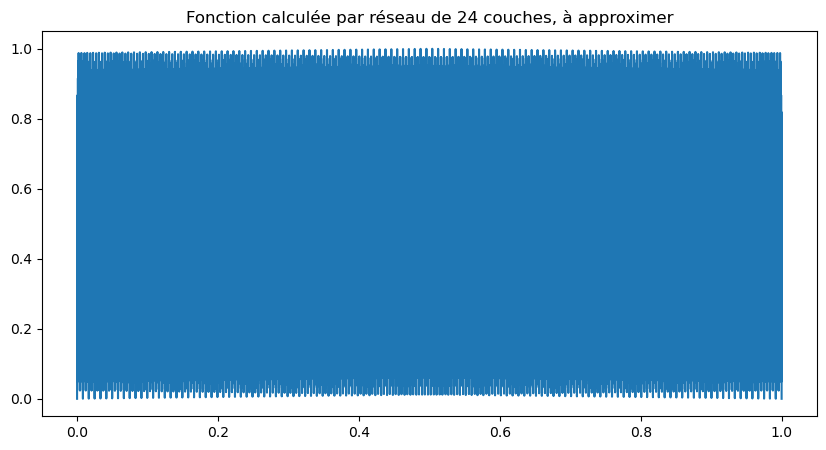

In [6]:
k=2
depth=k**3+4
n_train = 10000

x = torch.linspace(0, 1, n_train).view(-1, 1)

target = DeepTarget(depth=depth)
y_true = target(x).detach()

plt.figure(figsize=(10, 5))
plt.plot(x,y_true)
plt.title(f"Fonction calculée par réseau de {2*depth} couches, à approximer")
plt.show()

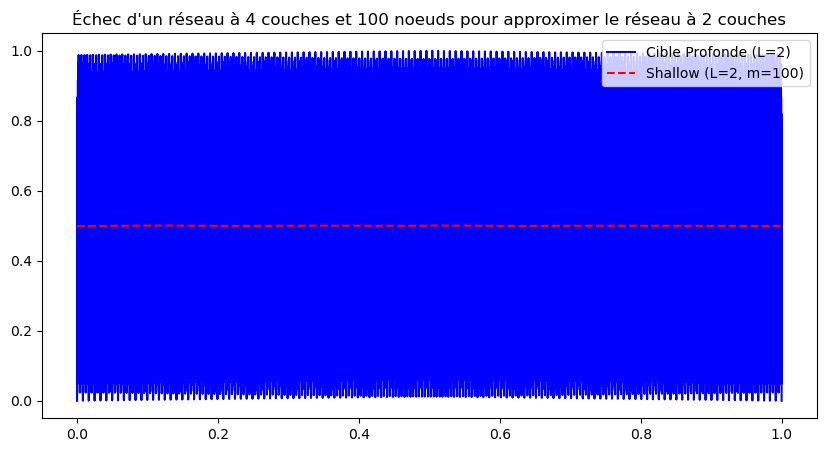

In [10]:
depth = 2
width = 100
epochs = 1000

model = DeepNetwork(width=width, depth=depth)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs): 
    optimizer.zero_grad()
    loss = nn.MSELoss()(model(x), y_true)
    loss.backward()
    optimizer.step()

plt.figure(figsize=(10, 5))
plt.plot(x, y_true, label=f"Cible Profonde (L={depth})", color="blue")
plt.plot(x, model(x).detach(), "--", label=f"Shallow (L={k}, m={width})", color="red")
plt.title(f"Échec d'un réseau à {2*k} couches et {width} noeuds pour approximer le réseau à {depth} couches")
plt.legend()
plt.show()

We stop here and we will try on simpler functions.